In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
generated = list(SeqIO.parse("/Users/mzvyagin/Documents/reverse_protein_design/likely-wood-857_1024concat_seqs_reconstructed.fasta", "fasta"))

In [3]:
generated_seqs = [s.seq for s in generated]

In [4]:
generated_protein_seqs = [s.translate(to_stop=True) for s in generated_seqs]

In [5]:
def gc_content(seqs):
    return [SeqUtils.GC(rec) for rec in seqs]

def seq_length(seqs):
    return [len(rec) for rec in seqs]

def molecular_weight(seqs):
    return [SeqUtils.molecular_weight(rec, "protein") for rec in seqs]

def isoelectric_point(seqs):
    return [IsoelectricPoint(seq).pi() for seq in seqs]

In [6]:
generated_paint_df = pd.DataFrame({
        "GC": gc_content(generated_seqs),
        "SequenceLength": seq_length(generated_seqs),
        "MolecularWeight": molecular_weight(generated_protein_seqs),
        "IsoelectricPoint": isoelectric_point(generated_protein_seqs),
})

In [7]:
generated_embeddings = np.load("/Users/mzvyagin/Documents/reverse_protein_design/likely-wood-857-1024concat_seqs_fasta_embeddings_mean.npy")

In [8]:
len(generated_embeddings)

1024

In [9]:
tsne = TSNE().fit_transform(generated_embeddings)

/Users/mzvyagin/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mzvyagin/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [10]:
def plot_tsne(data_proj: np.ndarray, paint: np.ndarray, paint_name: str, cmap: str = "viridis"):
    df = pd.DataFrame({"z0": data_proj[:, 0], "z1": data_proj[:, 1], paint_name: paint[:data_proj.shape[0]]})
    ax2 = df.plot.scatter(x='z0', y='z1',c=paint_name, colormap=cmap, alpha=0.4)
    plt.show()
    return df

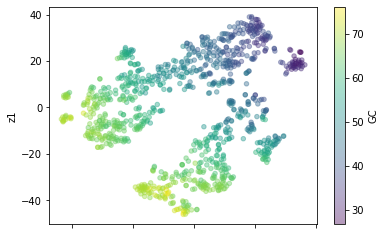

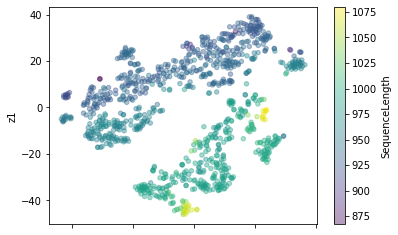

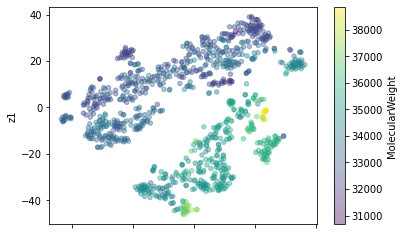

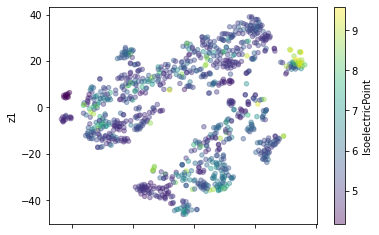

In [11]:
for key in generated_paint_df:
    gen_df = plot_tsne(tsne, generated_paint_df[key], key, cmap="viridis")

In [23]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(generated_embeddings)

In [24]:
kmeans

KMeans(n_clusters=2, random_state=0)

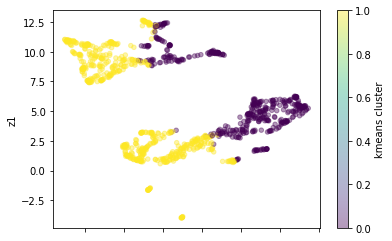

In [25]:
gen_df = plot_tsne(umap_output, kmeans.labels_, "kmeans cluster", cmap="viridis")

In [ ]:
kmeans.inertia_

In [ ]:
inertia = []
for x in tqdm(range(1, 15)):
    kmeans = KMeans(n_clusters=x, random_state=0).fit(generated_embeddings)
    inertia.append(kmeans.inertia_)

In [ ]:
plt.plot(inertia)
plt.title("inertia for k means")

In [ ]:
import sklearn

In [ ]:
sklearn.__version__

In [26]:
from sklearn.mixture import GaussianMixture

In [27]:
gmm = GaussianMixture(4, 
                     covariance_type='full', init_params="kmeans",
                     random_state=0).fit(generated_embeddings)

In [28]:
gmm.bic(generated_embeddings)

-891376.7024534121

In [29]:
labels = gmm.predict(generated_embeddings)

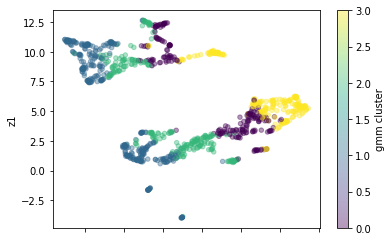

In [30]:
gen_df = plot_tsne(umap_output, labels, "gmm cluster", cmap="viridis")

In [ ]:
aic, bic = [], []
for i in tqdm(range(1, 15)):
    gmm = GaussianMixture(i, 
                     covariance_type='tied', init_params="kmeans",
                     random_state=0).fit(generated_embeddings)
    aic.append(gmm.aic(generated_embeddings))
    bic.append(gmm.bic(generated_embeddings))

In [ ]:
plt.plot(range(1, 15), aic, label="aic")
plt.plot(range(1, 15), bic, label="bic")
plt.legend()
plt.title("gmm full covariance")

In [31]:
from sklearn.cluster import SpectralClustering, AffinityPropagation, DBSCAN, OPTICS

In [32]:
sc = SpectralClustering()

In [33]:
sc_labels = sc.fit_predict(generated_embeddings)

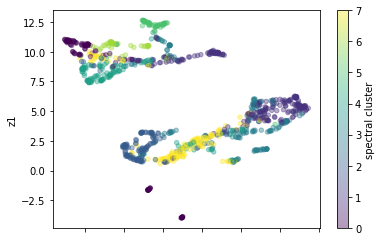

In [34]:
gen_df = plot_tsne(umap_output, sc_labels, "spectral cluster", cmap="viridis")

In [35]:
af = AffinityPropagation()

In [36]:
af_labels = af.fit_predict(generated_embeddings)

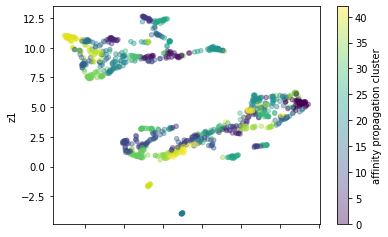

In [37]:
gen_df = plot_tsne(umap_output, af_labels, "affinity propagation cluster", cmap="viridis")

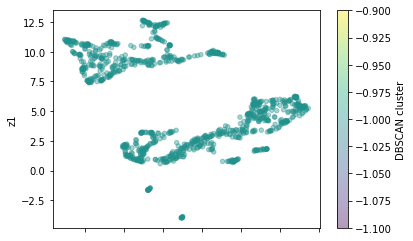

In [47]:
db = OPTICS(cluster_method="dbscan", metric="hamming")
db_labels = db.fit_predict(generated_embeddings)
gen_df = plot_tsne(umap_output, db_labels, "DBSCAN cluster", cmap="viridis")

In [122]:
from sklearn.cluster import FeatureAgglomeration

In [127]:
spectral_embedding = FeatureAgglomeration().fit_transform(umap_output)

In [128]:
spectral_embedding.shape

(1024, 2)

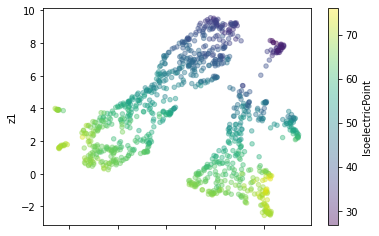

In [132]:
gen_df = plot_tsne(spectral_embedding, generated_paint_df['GC'], key, cmap="viridis")

In [12]:
from umap import UMAP

In [13]:
umap_output = UMAP(n_neighbors=30, min_dist=0.2, random_state=42).fit_transform(generated_embeddings)

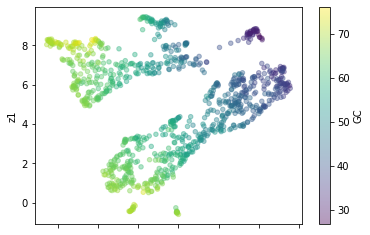

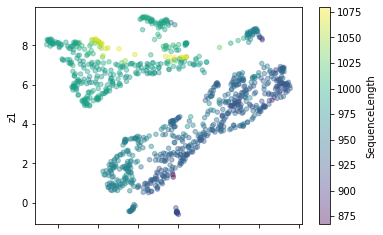

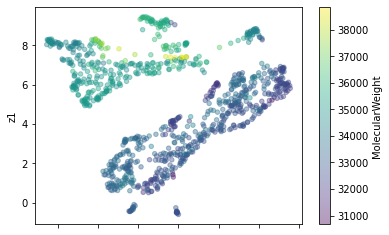

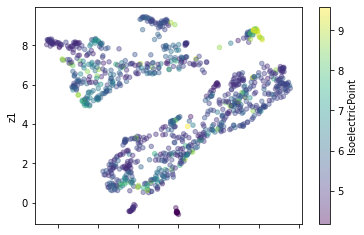

In [14]:
for key in generated_paint_df:
    gen_df = plot_tsne(umap_output, generated_paint_df[key], key, cmap="viridis")

In [18]:
import hdbscan

In [19]:
labels = hdbscan.HDBSCAN(
    # min_samples=25,
    min_cluster_size=30,
    # metric="cityblock"
).fit_predict(umap_output)

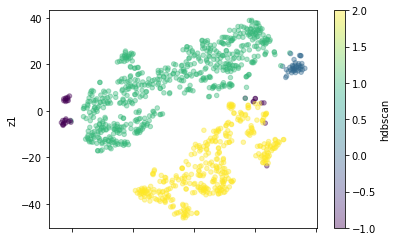

In [20]:
gen_df = plot_tsne(tsne, labels, "hdbscan", cmap="viridis")

In [21]:
from collections import Counter

In [22]:
Counter(labels)

Counter({1: 587, 2: 366, -1: 33, 0: 38})

In [23]:
from math import ceil, floor
import random
random.seed(0)

In [24]:
(labels == -1).nonzero()[0]

array([  31,   39,  168,  182,  193,  204,  245,  273,  287,  289,  292,
        298,  346,  362,  381,  476,  541,  577,  579,  583,  628,  654,
        764,  777,  786,  823,  878,  887,  912,  913,  948, 1000, 1014])

In [26]:
#sample from the clusters based on the cluster size
# 96 * (cluster_size / N_seqs)
sampled_sequences = {}
for i in range(-1, 3):
    # get the indices that are part of that cluster
    indices = list((labels == i).nonzero()[0])
    cluster_size = len(indices)
    num_sequences_to_sample = floor(96 * (cluster_size/1024))
    sample = random.sample(indices, num_sequences_to_sample)
    sampled_sequences[i] = sample

In [27]:
sampled_sequences

{-1: [786, 878, 168],
 0: [487, 945, 839],
 1: [731,
  542,
  860,
  644,
  394,
  903,
  241,
  500,
  242,
  171,
  446,
  950,
  252,
  551,
  178,
  134,
  596,
  855,
  1004,
  180,
  636,
  791,
  562,
  371,
  992,
  803,
  930,
  464,
  112,
  985,
  27,
  167,
  721,
  1,
  889,
  605,
  436,
  585,
  115,
  340,
  1015,
  402,
  426,
  244,
  977,
  813,
  162,
  144,
  569,
  907,
  877,
  192,
  537,
  991,
  511],
 2: [999,
  169,
  763,
  478,
  756,
  309,
  833,
  811,
  404,
  625,
  118,
  827,
  549,
  449,
  794,
  350,
  405,
  277,
  283,
  278,
  46,
  854,
  933,
  365,
  669,
  99,
  114,
  960,
  175,
  221,
  54,
  109,
  989,
  966]}

In [ ]:
import pickle
with open("cluster_sequence_samples.pkl", "wb") as f:
    f.write(pick

In [31]:
sampled_indices = []
[sampled_indices.extend(s) for s in sampled_sequences.values()]

[None, None, None, None]

In [32]:
len(sampled_indices)

95

In [53]:
len(set(sampled_indices))

95

In [58]:
generated[0].id

'MDHSyntheticSequence-LikelyWood857_0'

In [59]:
for n, i in enumerate(generated):
    i.name += "_index{}".format(n)
    i.id += "_index{}".format(n)
    i.description += "_index{}".format(n)

In [60]:
generated_protein_records = []
for s in generated:
    protein_record = s.translate(to_stop=True)
    protein_record.name = s.name + "_translated"
    protein_record.description = s.description + "_translated"
    protein_record.id = s.id + "_translated"
    generated_protein_records.append(protein_record)

In [61]:
generated_protein_records[0].seq

Seq('MKVTVVGAGAVGASCAEYIAIKDFASEVVLLDIKEGYAEGKAMDLMQTASLNGF...LEL')

In [62]:
sampled_protein_records = []
for x in sampled_indices:
    sampled_protein_records.append(generated_protein_records[x])

In [63]:
len(sampled_protein_records)

95

In [64]:
sampled_gene_records = []
for x in sampled_indices:
    sampled_gene_records.append(generated[x])

In [65]:
import os
os.getcwd()

'/Users/mzvyagin/Documents/gene_transformer/examples/perlmutter/notebook'

In [66]:
SeqIO.write(sampled_protein_records, "likely-wood-857-sampled_from_clusters_95_seqs_translated.fasta", "fasta")

95

In [67]:
sampled_protein_records[0].name

'MDHSyntheticSequence-LikelyWood857_529_index786_translated'

In [68]:
names = [s.name for s in sampled_protein_records]

In [69]:
len(names)

95

In [71]:
len(set(names))

95

In [73]:
for s in sampled_protein_records:
    SeqIO.write(s, "likely-wood-857-sampled_from_clusters_95_seqs_translated/{}.fasta".format(s.name), "fasta")